In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import *

# 2自由度制御

以下のシステムを想定します。

<img src='two_degrees_of_freedom_control_with_d_bd.drawio.svg'>

入力$r$、$d$と出力$y$の関係は以下のようになります。

\begin{eqnarray}
u_{ff} &=& \frac{F(s)}{P(s)} r \\
u_{fb} &=& K(s)( F(s)r - y ) \\
y &=& P(s)( u_{ff} + u_{fb} + d ) \\
  &=& F(s) r + \frac{P(s)}{1+K(s)P(s)}d
\end{eqnarray}

## 目標値応答

$d=0$としたときの$r$から$y$への伝達関数が目標値応答となります。
$F(s)$目標値応答そのものの動特性となります。


## 外乱応答

$r=0$としたときの$d$から$y$への伝達関数が外乱応答となります。
FB制御器$K(s)$の設計に応じて外乱を抑制することができます。


## 補足:低次な制御対象に対するFF補償

$P(s)$に1次遅れを想定します。

\begin{equation*}
P(s) = \frac{\omega_0}{s+\omega_0}
\end{equation*}

また、（欲張って）$F(s)=1$とします。（$F(s)$に相当する計算は目標軌道生成に託し、その結果として$r$が得られているという想定。）

すると、コントローラ上へ

\begin{equation*}
\frac{F(s)}{P(s)} = \frac{s+\omega_0}{\omega_0} = \frac{s}{\omega_0} + 1
\end{equation*}

を実装することになります。


何かと敬遠されがちな微分計算が入っていますが、目標軌道$r$を連続空間で導出している場合は導出時にその微分値$\dot{r}$も併せて（離散化の影響を受けない精度で）導出できる場合があります。

仮に$r$に合わせて$\dot{r}$も利用できると仮定すると、




\begin{eqnarray}
u_{ff} = \frac{F(s)}{P(s)} r = \left\{ \frac{s}{\omega_0} + 1 \right\} r = \frac{1}{\omega_0}\dot{r} + r
\end{eqnarray}

とすることができます。

仮に$r$を位置の目標軌道とすると、その1階微分や2階微分は速度や加速度に相当し、目標軌道として位置・速度・加速度を利用することで2次遅れ程度の制御対象であれば制御周期毎の微分処理を実施せずにFF補償の計算が可能になります。


## シミュレーション

$P(s)$を角周波数$\omega_0$[rad/s]をカットオフ周波数に持つ1次遅れ系を想定します。
\begin{equation*}
P(s) = \frac{\omega_0}{s+\omega_0}
\end{equation*}


$K(s)$として定数ゲインを想定します。(P制御)
\begin{equation*}
K(s) = G_p
\end{equation*}


$r$はステップ信号を時定数2[s]の単純移動平均とさらに時定数1[s]の単純移動平均した信号を想定します。

$d$は2.5[s]から振幅10のステップ信号を想定します。

コントローラへの実装を意識してlsim()を使わずにシミュレーションを実装します。
（lsim()使うとy=1\*rとなるだけなので。）

In [2]:
# シミュレーション環境設定
control_cycle = 1e-3
simulation_time = 5

# 制御対象設定
omega_0 = 3

# FB制御器設定
G_p = 10

# 目標軌道設定
start_time = 1
amplitude = 10   # 振幅
sma1_td = 2       # 移動平均時定数1
sma2_td = 1       # 移動平均時定数2

# 外乱設定
d_start_time = 2.5
d_amplitude = 10


In [3]:
# シミュレーション時間リスト生成
list_time = np.arange(0,simulation_time,control_cycle)

# 制御対象システム生成
P_tf_con = tf([omega_0], [1., omega_0])
P_ss_con = tf2ss( P_tf_con )
P_ss_dig = c2d(P_ss_con, control_cycle, method='tustin')

# 目標軌道生成
sma1_window_size = int( sma1_td / control_cycle )
sma1_window = np.ones(sma1_window_size)/sma1_window_size
sma2_window_size = int( sma2_td / control_cycle )
sma2_window = np.ones(sma2_window_size)/sma2_window_size
step = amplitude * (start_time < list_time)
step_sma1 = np.convolve(step,sma1_window,mode="full")
step_sma2 = np.convolve(step_sma1,sma2_window,mode="full")
dot_step_sma2 = np.diff( step_sma2 ) # この目標起動の生成方法ではオフラインですが結局ここで微分してます
list_r = step_sma2[0:len(list_time)]
list_dot_r = dot_step_sma2[0:len(list_time)] / control_cycle

# 外乱生成
list_d = d_amplitude * ( (d_start_time < list_time) )

In [4]:
# 初期値
x = 0
dot_x = 0
y = 0

# シミュレーション格納用リスト
list_y = np.empty(0)
list_u_ff = np.empty(0)
list_u_fb = np.empty(0)

# シミュレーション
for (r,dot_r,d) in zip(list_r,list_dot_r,list_d):
    
    # FF制御器計算
    u_ff = dot_r / omega_0 + r
    
    # FB制御器計算
    u_fb = G_p * ( r - y )
    
    # 次状態計算
    dot_x = P_ss_dig.A * x + P_ss_dig.B * ( u_ff + u_fb + d )
    
    # 出力計算
    y = P_ss_dig.C * x + P_ss_dig.D * ( u_ff + u_fb + d )
    
    # 現状態更新
    x = dot_x
    
    # 結果の格納
    list_u_ff = np.append( list_u_ff,u_ff )
    list_u_fb = np.append( list_u_fb,u_fb )
    list_y = np.append( list_y,y )


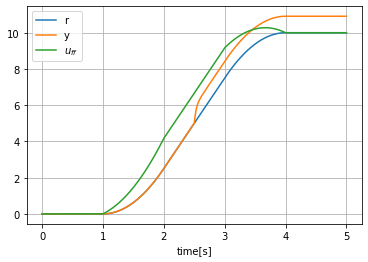

In [5]:
plt.figure()
plt.plot( list_time, list_r, label="r" )
plt.plot( list_time, list_y, label="y" )
plt.plot( list_time, list_u_ff, label=r"$u_{ff}$" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()
